##Makeover Monday | 2026/W1 Tallest Rollercoasters
Data sourced from Tripsavvy.com's article **"The 15 Tallest Roller Coasters in the World Will Take You to New Heights"** published on April 16, 2024 (Arthur Levine). The purpose of this script it to load the data in via the published data set compiled by the [Makeover Monday](https://makeovermonday.co.uk/) team for use in the Tableau Makeover Monday Data Visualization challenge. Part of this notebook will also do initial EDA of the data, data transformation and reshaping and output to google sheets for seamless connection to Tableau Public for final visualization.

* Article Link: https://www.tripsavvy.com/tallest-roller-coasters-in-the-world-3226411
* Compiled Data (published by Makeover Monday): https://data.world/makeovermonday/2026w2-tallest-rollercoasters

Final Outputs:
- df (rollercoasters): cleaned + geocoded rollercoasters (lat/lon)
- paths: densified curve + drop segments for Tableau map layers
- Tableau Dashboard: [Where in the World are the Tallest RollerCoasters?](https://public.tableau.com/app/profile/allison.jones/viz/MoM2026_w1RollerCoasters/WhereintheWorldaretheTallestRollerCoasters)

In [ ]:
# !pip install c #install this library for getting your geocoding coordinates from City, State and Country

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_excel('https://query.data.world/s/g2wf3svdihbfo75un3vxlkrll4chyi?dws=00000')

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,13,13,Kingda Ka,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,13,6,USA,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,13,11,"Sandusky, OH",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drop (ft),13.0,NaN,NaN,NaN,315.769231,49.005363,256.0,300.0,306.0,328.0,418.0


In [ ]:
df.head(13) # Data set is small, there are only 13 rollercoasters so I want to show all 13

,Name,Country,City,Drop (ft)
0,Kingda Ka,USA,"Jackson, NJ",418
1,Top Thrill Dragster,USA,"Sandusky, OH",400
2,Red Force,Spain,"Salou, Tarragona",345
3,Superman: Escape from Krypton,USA,"Valencia, CA",328
4,Fury 325,USA,"Charlotte, NC",320
5,Steel Dragon 2000,Japan,Nagashima,307
6,Leviathan,Canada,"Maple, Ontario",306
7,Millenium Force,USA,"Sandusky, OH",300
8,Intimidator 305,USA,"Doswell, VA",300
9,Orion,USA,"Mason, OH",300


In [ ]:
df.dtypes

,0
Name,object
Country,object
City,object
Drop (ft),int64


## The Shape of the Data
What does the shape of this data tell us and how should we reshape it and load it to BigQuery for ETL to Tableau via Google Sheets (connected sheets)? We can see from the 3 cell blocks above that the data set is small - only 13 records (13 rollercoasters to be exact), because of this, I can design this viz layout manually with fixed landing columns - no Top N's) without any performance conecerns. This is also a small enough N for a bar chart to be easily digestible, and for points on a map to be easily consumed.
There are also two fields that could be considered "Geographical" - but the "City" field is a mixed field and that if we were to pull that into Tableau as is - it would not be mapped to City correctly (Mason, OH is not a City, it's a City and a State in the USA).
Also - the field "Drop (ft)" will immediately cause errors if I try to load this into BigQuery because its field name is incompatable with BigQuery schema naming convention.
A quick visual scan of the data tells me that most of the records (if not all) predominantly fall in the Northern Hemisphere - which gives me an idea to do a Map Layer based visualization that allowed me to use the bottom half of the map - Southern Hemisphere - as a space for storytelling about the Rollercoaster's "Drop" and relating that to their real geographical points in the Northern Hemisphere.

#Plan for cleaning and reshaping the Data : my plan for a Viz
In the next steps I will:
* Rename the Drop (ft) column as well as Name, Country is City. Note: renaming Name, Country is City and not necessary but I am doing it all lower case (snake case) for consistency
* Create a new City and State/Region Column from the old City Column
* Enrich the Geogrpahical data with Geospatial data (latitude, longitude)
* Reshape and prepare my data for my Tableau dashboard that connects my location points to "Drop" points

In [ ]:
#BigQuery does not like (or accept) weird names for columns which are nice for human readable table.
## this step renames the "Drop (ft)" column to be compatible with BigQuery and easy for ingestion : remove spaces/special characters so exports + SQL are painless
df = df.rename(columns={
    "Name": "name",
    "Country": "country",
    "City": "city",
    "Drop (ft)": "drop_ft"
})

df.head()

,name,country,city,drop_ft
0,Kingda Ka,USA,"Jackson, NJ",418
1,Top Thrill Dragster,USA,"Sandusky, OH",400
2,Red Force,Spain,"Salou, Tarragona",345
3,Superman: Escape from Krypton,USA,"Valencia, CA",328
4,Fury 325,USA,"Charlotte, NC",320


In [ ]:
##For some of the rollercoasters, the City field is actualy City, State/Region, which when you pull it into Tableau, it will break geocoding
##This section renames the City field as "City_old" and loops through rows and pulls out City (before ",") and State/Region after ", "

df['city_old'] = df["city"]
split = df["city_old"].str.split(",", n=1, expand=True) # Split on first comma into two groups
df["city"] = split[0].str.strip()
#if there are any Citys that have no State then state_region = None
df["state_region"] = split[1].str.strip() if split.shape[1] > 1 else None

df.head(13) #print all 13 (because you can)

,name,country,city,drop_ft,city_old,state_region
0,Kingda Ka,USA,Jackson,418,"Jackson, NJ",NJ
1,Top Thrill Dragster,USA,Sandusky,400,"Sandusky, OH",OH
2,Red Force,Spain,Salou,345,"Salou, Tarragona",Tarragona
3,Superman: Escape from Krypton,USA,Valencia,328,"Valencia, CA",CA
4,Fury 325,USA,Charlotte,320,"Charlotte, NC",NC
5,Steel Dragon 2000,Japan,Nagashima,307,Nagashima,None
6,Leviathan,Canada,Maple,306,"Maple, Ontario",Ontario
7,Millenium Force,USA,Sandusky,300,"Sandusky, OH",OH
8,Intimidator 305,USA,Doswell,300,"Doswell, VA",VA
9,Orion,USA,Mason,300,"Mason, OH",OH


In [ ]:
#Using the geopy library I will now *attempt* to get the coordinates from the City, State_Region and Country
##See the documentation from Nominatim (nominatim.org) for further information
#Note: Geocoding uses Nominatim via geopy and may take a few minutes due to rate limits
# if this was a larger dataset or if I was running this often, I would consider doing it in batches (large data sets) and saving/caching result to a table in BigQuery or csv.

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="allison_mom_rollercoasters")  # change string if you want
geocode = RateLimiter(
    geolocator.geocode,
    min_delay_seconds=1,      # be kind to the service
    max_retries=2,
    error_wait_seconds=2,
    swallow_exceptions=True
)

# Build a query string that adapts when state_region is missing
def build_query(row):
    parts = [row.get("city"), row.get("state_region"), row.get("country")]
    parts = [p for p in parts if pd.notna(p) and str(p).strip() != ""]
    return ", ".join(parts)

df["geo_query"] = df.apply(build_query, axis=1)

# Cache dictionary so reruns don't re-hit the API
cache = {}

def geocode_cached(q):
    if q in cache:
        return cache[q]
    loc = geocode(q)
    if loc is None:
        cache[q] = (None, None)
    else:
        cache[q] = (loc.latitude, loc.longitude)
    return cache[q]

df[["latitude", "longitude"]] = df["geo_query"].apply(
    lambda q: pd.Series(geocode_cached(q))
)

df[["geo_query", "latitude", "longitude"]].head(13)

,geo_query,latitude,longitude
0,"Jackson, NJ, USA",39.776505,-74.862385
1,"Sandusky, OH, USA",41.295156,-83.155544
2,"Salou, Tarragona, Spain",41.076819,1.144041
3,"Valencia, CA, USA",34.413194,-118.559849
4,"Charlotte, NC, USA",35.227209,-80.843083
5,"Nagashima, Japan",32.183459,130.166311
6,"Maple, Ontario, Canada",43.859495,-79.506897
7,"Sandusky, OH, USA",41.295156,-83.155544
8,"Doswell, VA, USA",37.860140,-77.464149
9,"Mason, OH, USA",39.360059,-84.309939


In [ ]:
#Sanity Check to make sure you have All of your Latitudes and Longitudes
df.head(13)

,name,country,city,drop_ft,city_old,state_region,geo_query,latitude,longitude
0,Kingda Ka,USA,Jackson,418,"Jackson, NJ",NJ,"Jackson, NJ, USA",39.776505,-74.862385
1,Top Thrill Dragster,USA,Sandusky,400,"Sandusky, OH",OH,"Sandusky, OH, USA",41.295156,-83.155544
2,Red Force,Spain,Salou,345,"Salou, Tarragona",Tarragona,"Salou, Tarragona, Spain",41.076819,1.144041
3,Superman: Escape from Krypton,USA,Valencia,328,"Valencia, CA",CA,"Valencia, CA, USA",34.413194,-118.559849
4,Fury 325,USA,Charlotte,320,"Charlotte, NC",NC,"Charlotte, NC, USA",35.227209,-80.843083
5,Steel Dragon 2000,Japan,Nagashima,307,Nagashima,None,"Nagashima, Japan",32.183459,130.166311
6,Leviathan,Canada,Maple,306,"Maple, Ontario",Ontario,"Maple, Ontario, Canada",43.859495,-79.506897
7,Millenium Force,USA,Sandusky,300,"Sandusky, OH",OH,"Sandusky, OH, USA",41.295156,-83.155544
8,Intimidator 305,USA,Doswell,300,"Doswell, VA",VA,"Doswell, VA, USA",37.860140,-77.464149
9,Orion,USA,Mason,300,"Mason, OH",OH,"Mason, OH, USA",39.360059,-84.309939


##**Now that I have the descriptive (enriched) Data I will reshape it to create each rollercoasters geographic location to the end point of its drop "bar" in Tableau**

Why am I doing this? I *could* bring this clean, enriched table directly into Tableau and create a neat Dual Axis Map in Tableau and a Bar chart. I could even try to float a Sankey-style object on top to suggest a relationship between the rollercoasts location and its drop (I thought about).

But that wouldn't tell the data story. In order for me to connect the proverbial dots and make the relationship part of the visual story, I need to reshape the data so Tableau has the geometry and paths to draw.

I will do that with 3 tables:
* **RollerCoasters Table** (Descriptive, real geometry lat/lon)
  * *Purpose* : Where does each RollerCoster exist in the real world (on the map)
  * *What it contains* : Real lat/long and descriptive fields (the df. above!)
* **Drop_Bar Table** (new table/manufactured geometry)
  * *Purpose* :  Where does each rollder coasts "drop value" live in my designed chart space
  * *What it contains* : Coordinate that define the bar placement and the bar end pont (i.e. a fixed latitude bad ( and scaled lonitude that repesents the drop in the southern hemispher of the map). NOTE: These will be sorted by Drop DESC.
* **Paths Table** (Path Geometry / Relationship Table)
  * *Purpose* : What is the path from the rel map location to the bar endpoint
  * *What it contains* : a densified set of points creating a path that tablea can draq as a long from (lon, lat) to (bar_end_lon, bar_lat).

  This is really important to think about
  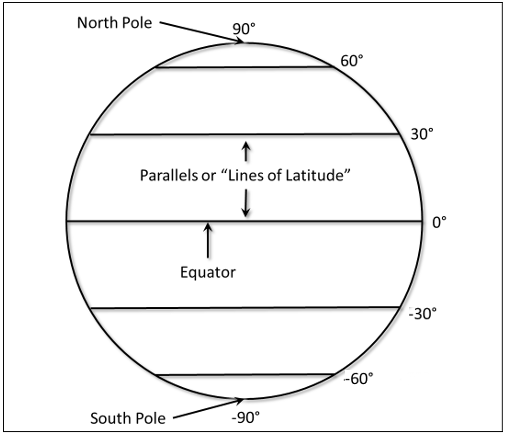

In [ ]:
##Create Drop_Bar table
drop_bar = df.copy()

# where the landing columns start + how spaced
BAR_BASE_LAT = -60.0 #-50.0
BAR_ROW_STEP = -2.0
LANDING_START_LON = -100.0 #-20.0, -40.0 -60.0 (-100 is the middle of the USA roughly) small (more -) : orientation more to the left of hemisphere
LANDING_STEP_LON  = 16.0  # 2.0, 4.0, 8.0 : larger = greater width

METRIC = "drop_ft" #when you want to order by
METRIC2 = "longitude" #when you want to order by longitude (left to right geographically)

drop_bar[METRIC] = drop_bar[METRIC].astype(float)
drop_bar[METRIC2] = drop_bar[METRIC2].astype(float)

#first create the bar_row, bar_lat and bar_end_lon for the METRIC position
drop_bar = drop_bar.sort_values([METRIC, "name"], ascending=[False, True]).reset_index(drop=True) ## stable order
drop_bar["rank"] = drop_bar.index + 1 # rank + row position
drop_bar["bar_row"] = drop_bar.index
# drop_bar["bar_lat"] = BAR_BASE_LAT + (drop_bar['drop_ft'])/10 #use this if you want a dynamic end point... using drop or rank of whatever but remember the bulge of the world!
drop_bar["bar_lat"] = BAR_BASE_LAT #I'm just going to drop it to base!
drop_bar["bar_end_lon"] = LANDING_START_LON + (drop_bar["rank"] - 1) * LANDING_STEP_LON # landing x based on rank (unique!)

#second create the bar_row2, bar_lat2 and bar_end_lon2 for the METRIC2 position
#LONGITUDE sort (ASC: more negative = left, more positive = right) -> bar_end_lon2
#IMPORTANT: do NOT overwrite drop_bar order; compute rank2 separately then merge back.
lon_rank = (
    drop_bar[["name", "country", "city", METRIC2]]
    .sort_values([METRIC2, "name"], ascending=[True, True])   # <-- KEY CHANGE (ASC)
    .reset_index(drop=True)
)
lon_rank["rank2"] = lon_rank.index + 1
lon_rank["bar_row2"] = lon_rank.index
# lon_rank["bar_lat2"] = BAR_BASE_LAT + (drop_bar['longitude'])/10 #use this if you want a dynamic end point... using drop or rank of whatever but remember the bulge of the world!
lon_rank["bar_lat2"] = BAR_BASE_LAT
lon_rank["bar_end_lon2"] = LANDING_START_LON + (lon_rank["rank2"] - 1) * LANDING_STEP_LON

# merge longitude-based placement back onto the DROP-sorted table
drop_bar = drop_bar.merge(
    lon_rank[[
        "name", "country", "city",
        "rank2", "bar_row2", "bar_lat2", "bar_end_lon2"]],
    on=["name", "country", "city"],
    how="left"
)

#sanity check
drop_bar.head(13) #doublecheck!

,name,country,city,drop_ft,city_old,state_region,geo_query,latitude,longitude,rank,bar_row,bar_lat,bar_end_lon,rank2,bar_row2,bar_lat2,bar_end_lon2
0,Kingda Ka,USA,Jackson,418.0,"Jackson, NJ",NJ,"Jackson, NJ, USA",39.776505,-74.862385,1,0,-60.0,-100.0,8,7,-60.0,12.0
1,Top Thrill Dragster,USA,Sandusky,400.0,"Sandusky, OH",OH,"Sandusky, OH, USA",41.295156,-83.155544,2,1,-60.0,-84.0,4,3,-60.0,-52.0
2,Red Force,Spain,Salou,345.0,"Salou, Tarragona",Tarragona,"Salou, Tarragona, Spain",41.076819,1.144041,3,2,-60.0,-68.0,9,8,-60.0,28.0
3,Superman: Escape from Krypton,USA,Valencia,328.0,"Valencia, CA",CA,"Valencia, CA, USA",34.413194,-118.559849,4,3,-60.0,-52.0,1,0,-60.0,-100.0
4,Fury 325,USA,Charlotte,320.0,"Charlotte, NC",NC,"Charlotte, NC, USA",35.227209,-80.843083,5,4,-60.0,-36.0,5,4,-60.0,-36.0
5,Steel Dragon 2000,Japan,Nagashima,307.0,Nagashima,None,"Nagashima, Japan",32.183459,130.166311,6,5,-60.0,-20.0,13,12,-60.0,92.0
6,Leviathan,Canada,Maple,306.0,"Maple, Ontario",Ontario,"Maple, Ontario, Canada",43.859495,-79.506897,7,6,-60.0,-4.0,6,5,-60.0,-20.0
7,Intimidator 305,USA,Doswell,300.0,"Doswell, VA",VA,"Doswell, VA, USA",37.860140,-77.464149,8,7,-60.0,12.0,7,6,-60.0,-4.0
8,Millenium Force,USA,Sandusky,300.0,"Sandusky, OH",OH,"Sandusky, OH, USA",41.295156,-83.155544,9,8,-60.0,28.0,3,2,-60.0,-68.0
9,Orion,USA,Mason,300.0,"Mason, OH",OH,"Mason, OH, USA",39.360059,-84.309939,10,9,-60.0,44.0,2,1,-60.0,-84.0


In [ ]:
#Create a Paths table
##this is a "densified" table of points that will allow tableau to draw a line from Rollercoasts (longitude,latitude) to Drop_Bar (bar_end_lon, bar_lat)
#we want Bezier-style to move from the Map points to the Bar

N_CURVE_POINTS = 30 #anywhere from 20-40 is cool
N_DROP_POINTS  = 12
CURVE = 0.15 # 0.15 subtle, 0.35 nice, 0.6 dramatic
SNAP_LAT = -6.0   # <-- set this to where you want the curve to "land" before dropping

def bezier_cubic(P0, P1, P2, P3, t):
    """Cubic Bézier point at parameter t in [0,1]."""
    return ((1-t)**3)*P0 + 3*((1-t)**2)*t*P1 + 3*(1-t)*(t**2)*P2 + (t**3)*P3

#run this first for your METRIC order (defined above)
# Base endpoints
endpoints = drop_bar[[
    "name", "country", "city","drop_ft",
    "longitude", "latitude",# start (real geo) point will go from here....
    "bar_end_lon","bar_lat"# end (bar endpoint) for METRIC point will end here
]].copy()

# build t grid
# tt = np.linspace(0, 1, N_CURVE_POINTS) # if you are ONLY building without drop
curve_t = np.linspace(0, 1, N_CURVE_POINTS)
drop_t  = np.linspace(0, 1, N_DROP_POINTS)

paths_metric = []

for _, r in endpoints.iterrows():
    lon0, lat0 = float(r["longitude"]), float(r["latitude"])
    # lon3, lat3 = float(r["bar_end_lon"]), float(r["bar_lat"]) #if you not build a drop use this
    #if you are building a drop
    lon_end = float(r["bar_end_lon"])
    lat_bar = float(r["bar_lat"])


    K  = np.array([lon_end, SNAP_LAT], dtype=float)  # Knee point directly above the bar end, at a shared latitude : this is if you a building a drip
    P0 = np.array([lon0, lat0], dtype=float)
    # P3 = np.array([lon3, lat3], dtype=float) #if you are not building a drop use this

    # direction vector and perpendicular
    # v = P3 - P0 #if you are not building a drop use this
    v = K - P0 #if you are building a drop use this
    dist = np.sqrt((v**2).sum())
    if dist == 0:
        continue

    perp = np.array([-v[1], v[0]])  # rotate 90°
    perp = perp / (np.sqrt((perp**2).sum()) + 1e-9)

    # choose bulge magnitude proportional to distance
    bulge = CURVE * dist
    # mid = (P0 + P3) / 2 #if you are not building a drop, use this
    mid = (P0 + K) / 2 #if you are buildign a drop use this

    # force the curve to bow "south" (down) or "north" (up)
    candidate = mid + perp * bulge
    # if candidate[1] > mid[1]:   # if it bows north, flip it : ensure control pts have lower lat than midpoint
    if candidate[1] < mid[1]:   # if it bows north, flip it : ensure control pts have higher lat than midpoint
        perp = -perp

    # control points along the path, offset by perpendicular bulge
    P1 = P0 + 0.25*v + perp * bulge
    P2 = P0 + 0.75*v + perp * bulge

    # Segment 1: curve points
    # for i, t in enumerate(tt, start=1): #if you are not building a drop use this
    #     pt = bezier_cubic(P0, P1, P2, P3, t) #if you are not building a drop use this
    for i, t in enumerate(curve_t, start=1):#if you are building a drop use this
        pt = bezier_cubic(P0, P1, P2, K, t) #if you are building a drop use this
        paths_metric.append({
            "name": r["name"],
            "country": r["country"],
            "city": r["city"],
            "MetricValue": r["drop_ft"],
            "Metric": "Drop ft", #drop_ft
            "segment": "curve",
            "path_order": i,
            "path_i": i,
            "t": float(t),
            "lon": float(pt[0]),
            "lat": float(pt[1]),
        })

    # Segment 2: vertical drop from SNAP_LAT down to bar_lat at same lon_end
    # (If you want it to drop to the bar baseline instead, use BAR_BASE_LAT here.)
    start_order = N_CURVE_POINTS
    for j, t in enumerate(drop_t, start=1):
        lat = SNAP_LAT + (lat_bar - SNAP_LAT) * t
        paths_metric.append({
            "name": r["name"],
            "country": r["country"],
            "city": r["city"],
            "MetricValue": r["drop_ft"],
            "Metric": "Drop ft", #drop_ft
            "segment": "drop",
            "path_order": start_order + j,
            "lon": lon_end,
            "lat": float(lat),
        })

paths_drop = pd.DataFrame(paths_metric)

#Run it again for your METRIC2
# Base endpoints
endpoints = drop_bar[[
    "name", "country", "city","drop_ft",
    "longitude", "latitude",# start (real geo) point will go from here....
    "bar_end_lon2","bar_lat2"# end (bar endpoint) for METRIC2 point will end here
]].copy()

# build t grid
# tt = np.linspace(0, 1, N_CURVE_POINTS) # if you are ONLY building without drop
curve_t = np.linspace(0, 1, N_CURVE_POINTS)
drop_t  = np.linspace(0, 1, N_DROP_POINTS)

paths_metric2 = []

for _, r in endpoints.iterrows():
    lon0, lat0 = float(r["longitude"]), float(r["latitude"])
    # lon3, lat3 = float(r["bar_end_lon2"]), float(r["bar_lat2"]) #if you not build a drop use this
    #if you are building a drop
    lon_end2 = float(r["bar_end_lon2"])
    lat_bar2 = float(r["bar_lat2"])


    K  = np.array([lon_end2, SNAP_LAT], dtype=float)  # Knee point directly above the bar end, at a shared latitude : this is if you a building a drip
    P0 = np.array([lon0, lat0], dtype=float)
    # P3 = np.array([lon3, lat3], dtype=float) #if you are not building a drop use this

    # direction vector and perpendicular
    # v = P3 - P0 #if you are not building a drop use this
    v = K - P0 #if you are building a drop use this
    dist = np.sqrt((v**2).sum())
    if dist == 0:
        continue

    perp = np.array([-v[1], v[0]])  # rotate 90°
    perp = perp / (np.sqrt((perp**2).sum()) + 1e-9)

    # choose bulge magnitude proportional to distance
    bulge = CURVE * dist
    # mid = (P0 + P3) / 2 #if you are not building a drop, use this
    mid = (P0 + K) / 2 #if you are buildign a drop use this

    # force the curve to bow "south" (down) or "north" (up)
    candidate = mid + perp * bulge
    # if candidate[1] > mid[1]:   # if it bows north, flip it : ensure control pts have lower lat than midpoint
    if candidate[1] < mid[1]:   # if it bows north, flip it : ensure control pts have higher lat than midpoint
        perp = -perp

    # control points along the path, offset by perpendicular bulge
    P1 = P0 + 0.25*v + perp * bulge
    P2 = P0 + 0.75*v + perp * bulge

    # Segment 1: curve points
    # for i, t in enumerate(tt, start=1): #if you are not building a drop use this
    #     pt = bezier_cubic(P0, P1, P2, P3, t) #if you are not building a drop use this
    for i, t in enumerate(curve_t, start=1):#if you are building a drop use this
        pt = bezier_cubic(P0, P1, P2, K, t) #if you are building a drop use this
        paths_metric2.append({
            "name": r["name"],
            "country": r["country"],
            "city": r["city"],
            "MetricValue": r["longitude"], #longitude
            "Metric": "Geography", #longitude
            "segment": "curve",
            "path_order": i,
            "path_i": i,
            "t": float(t),
            "lon": float(pt[0]),
            "lat": float(pt[1]),
        })

    # Segment 2: vertical drop from SNAP_LAT down to bar_lat at same lon_end
    # (If you want it to drop to the bar baseline instead, use BAR_BASE_LAT here.)
    start_order = N_CURVE_POINTS
    for j, t in enumerate(drop_t, start=1):
        lat = SNAP_LAT + (lat_bar - SNAP_LAT) * t
        paths_metric2.append({
            "name": r["name"],
            "country": r["country"],
            "city": r["city"],
            "MetricValue": r["longitude"], #latitude
            "Metric": "Geography", #longitude
            "segment": "drop",
            "path_order": start_order + j,
            "lon": lon_end2,
            "lat": float(lat),
        })

paths_lat = pd.DataFrame(paths_metric2)

paths = pd.concat([paths_drop, paths_lat], ignore_index=True)

In [ ]:
##Validation on One Rollercoaster
test_id = drop_bar.loc[0, "name"]  # top coaster
paths_test = paths[paths["name"] == test_id].sort_values("path_i")
paths_test.head(1)[["lon","lat"]], paths_test.tail(1)[["lon","lat"]]
##we should see the first row is the original longitude/latitue and the last row is the bar_end_lon/bar_lar from drop_bar

(         lon        lat
 0 -74.862385  39.776505,
       lon   lat
 587  12.0 -60.0)

In [ ]:
##compare the previous cell against this one
drop_bar[[
    "name",  "longitude","latitude",     # real geo coordinates (kept!)
    "bar_lat", "bar_end_lon", #this is your drop order
    "bar_lat2", "bar_end_lon2", #this is your geo-order
]].head(1)

,name,longitude,latitude,bar_lat,bar_end_lon,bar_lat2,bar_end_lon2
0,Kingda Ka,-74.862385,39.776505,-60.0,-100.0,-60.0,12.0


#Save to BigQuery Table
Save the New Tables (df and paths) to dedicated tables in my BigQuery warehouse
This is my final step before pushing it to Google Sheets that I will use to connect to Tableau Public.
Note: I generated Drop_Bar only to calculate bar_end_lon / bar_end_lon2 endpoints for path geometry but do not need these for the Tableau viz. Tableau uses Rollercoasters Table (df) + and Paths Table (paths) only

In [ ]:
#convert the df to target table in bigquery dataet
UPLOAD_TO_BQ = False # set True when you actually want to write tables

if UPLOAD_TO_BQ:
  project_id = 'your_project_id'
  destination_table1 = 'your_dataset.another_new_table'
  destination_table2 = 'your_dataset.another_new_table'

  df.to_gbq(
      destination_table=destination_table1,
      project_id=project_id,
      if_exists='replace' ## 'if_exists' options: 'fail', 'replace', 'append'
  )


  paths.to_gbq(
      destination_table=destination_table2,
      project_id=project_id,
      if_exists='replace' ## 'if_exists' options: 'fail', 'replace', 'append'
  )

/tmp/ipython-input-4031658918.py:6: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]
/tmp/ipython-input-4031658918.py:13: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  paths.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 10330.80it/s]


##**Tableau Public Dashboard**
Check out the [final dashboard](https://public.tableau.com/views/MoM2026_w1RollerCoasters/WhereintheWorldaretheTallestRollerCoasters?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link) the brings to life all these crazy path points and connects the dots from the real map geolocation to a visual space that represents the rollercoaster data. Hopefully this shows the connection between location and rollercoasters in the world, highlighting that the southern hemisphere is sorely left out, and the East Coast of the United States is dominated in the tall roller coaster market - globally (according to TripSavvy's data!)
![Where in the World are the Tallest RollerCoasters](images/tableaudashboard_mom_2026_w1_rollercoasters.png)